# **BERT para tareas de preguntas/respuestas**

In [ ]:
#Montar Colab en Drive
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install transformers
!pip install datasets
!pip install pandas
!pip install seaborn
!pip install beautifulsoup4
!pip install requests
!pip install matplotlib
!pip install accelerate


In [1]:
from transformers import BertTokenizerFast, BertForQuestionAnswering, pipeline, \
                         DataCollatorWithPadding, TrainingArguments, Trainer, \
                         AutoModelForQuestionAnswering, AutoTokenizer
from datasets import Dataset
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import requests

In [2]:
bert_tokenizer = BertTokenizerFast.from_pretrained('bert-large-uncased', return_token_type_ids=True)

qa_bert = BertForQuestionAnswering.from_pretrained('bert-large-uncased')

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
qa_df = pd.read_csv('./qa.csv')
qa_df.shape

(29989, 5)

In [4]:
qa_df.head()

,question,context,start_positions,end_positions,answer
0,What sare the benifts of the blood brain barrir?,Another approach to brain function is to exami...,56,60,isolated from the bloodstream
1,What is surrounded by cerebrospinal fluid?,Another approach to brain function is to exami...,16,16,brain
2,What does the skull protect?,Another approach to brain function is to exami...,11,11,brain
3,What has been injected into rats to produce pr...,Another approach to brain function is to exami...,153,153,chemicals
4,What can cause issues with how the brain works?,Another approach to brain function is to exami...,93,94,brain damage


In [5]:
qa_df.iloc[0]

question            What sare the benifts of the blood brain barrir?
context            Another approach to brain function is to exami...
start_positions                                                   56
end_positions                                                     60
answer                                 isolated from the bloodstream
Name: 0, dtype: object

In [6]:
# índice 56, 57, 58, 59 y 60, incluyen la pregunta durante la codificación
bert_tokenizer.decode(bert_tokenizer.encode(qa_df.iloc[0].question, qa_df.iloc[0].context)[56:61])

'isolated from the bloodstream'

In [7]:
# solo usar 4,000 ejemplos
qa_dataset = Dataset.from_pandas(qa_df.sample(4000, random_state=42))

# Dataset tiene un método preconstruido train test split
qa_dataset = qa_dataset.train_test_split(test_size=0.2)

In [8]:
# preprocesamiento estándar aquí con truncamiento para truncar texto más largo
def preprocess(data):
    return bert_tokenizer(data['question'], data['context'], truncation=True)

qa_dataset = qa_dataset.map(preprocess, batched=True)

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

In [9]:
# congelar todas menos las últimas 2 capas de codificador en BERT para acelerar el entrenamiento
for name, param in qa_bert.bert.named_parameters():
    if 'encoder.layer.22' in name:
        break
    param.requires_grad = False  # deshabilitar el entrenamiento en BERT

In [10]:
data_collator = DataCollatorWithPadding(tokenizer=bert_tokenizer)

In [11]:
batch_size = 32
epochs = 2

training_args = TrainingArguments(
    output_dir='./snips_clf/resultspreguntas',
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    logging_dir='./snips_clf/resultspreguntas',
    save_strategy='epoch',
    logging_steps=10,
    evaluation_strategy='epoch',
    load_best_model_at_end=True,
    report_to="all"
)

trainer = Trainer(
    model=qa_bert,
    args=training_args,
    train_dataset=qa_dataset['train'],
    eval_dataset=qa_dataset['test'],
    data_collator=data_collator
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [12]:
trainer.evaluate()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 5.862941741943359,
 'eval_runtime': 112.0013,
 'eval_samples_per_second': 7.143,
 'eval_steps_per_second': 0.223}

In [13]:
#trainer.train()

In [14]:
# From Huggingface: https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad

squad_pipe = pipeline("question-answering", "bert-large-uncased-whole-word-masking-finetuned-squad")

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
squad_pipe("How is our time?", "Our time is limited, so don’t waste it living someone else’s life. Don’t be trapped by dogma – which is living with the results of other people’s thinking.")

{'score': 0.8602685928344727, 'start': 12, 'end': 19, 'answer': 'limited'}

In [16]:
schopenhauer = """Arthur Schopenhauer was a German philosopher who lived from 1788 to 1860.
He is known for his pessimistic views on life and the world. Schopenhauer believed that life
is full of suffering and that happiness is difficult to achieve. He thought that our desires
and cravings only lead to more dissatisfaction. Despite his gloomy outlook, Schopenhauer's ideas
have had a significant impact on philosophy and continue to be studied today."""

squad_pipe("What is Schopenhauer known for?", schopenhauer)

{'score': 0.4576887786388397,
 'start': 90,
 'end': 133,
 'answer': 'his pessimistic views on life and the world'}

In [17]:
schopenhauer = """Arthur Schopenhauer was a German philosopher who lived from 1788 to 1860.
He is known for his pessimistic views on life and the world. Schopenhauer believed that life
is full of suffering and that happiness is difficult to achieve. He thought that our desires
and cravings only lead to more dissatisfaction. Despite his gloomy outlook, Schopenhauer's ideas
have had a significant impact on philosophy and continue to be studied today."""

squad_pipe("What did Schopenhauer think our desires lead us to?", schopenhauer)

{'score': 0.5538555979728699,
 'start': 291,
 'end': 306,
 'answer': 'dissatisfaction'}

In [18]:
nietzsche = """Es sumamente destacable la influencia que ejerció sobre Nietzsche el filósofo
también alemán Arthur Schopenhauer, a quien consideró su maestro, si bien es cierto que no siguió
de manera dogmática las ideas de este último, y en muchos aspectos se aleja de su pensamiento llegando
incluso a realizar una crítica radical de sus ideas filosóficas.."""

squad_pipe("¿A quién consideraba Nietzsche como su maestro?", nietzsche)

{'score': 0.016026679426431656,
 'start': 93,
 'end': 112,
 'answer': 'Arthur Schopenhauer'}

In [19]:
# visualize logits
large_tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

qa_input = large_tokenizer(  # tokenize our example
    "What did Schopenhauer think our desires lead us to?", schopenhauer,
    return_tensors='pt'
)

In [20]:
large_qa_bert = AutoModelForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

output = large_qa_bert(**qa_input)  # pasa el input a través de nuestro modelo QA
output

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[ -6.3673,  -3.8977,  -8.3531,  -7.8646,  -8.4869,  -8.6703,  -8.6487,
          -8.0523,  -7.5841,  -7.3389,  -7.2980,  -7.4922,  -5.2942, -10.0389,
          -6.3672,  -5.0888,  -6.3419,  -7.7249,  -7.4977,  -7.2720,  -7.4024,
          -6.9962,  -5.2671,  -5.1396,  -7.8049,  -6.7724,  -7.4892,  -5.6100,
          -7.6842,  -5.9704,  -6.3672,  -5.5853,  -7.8194,  -7.0375,  -7.9403,
          -6.7972,  -5.0148,  -6.3272,  -7.4510,  -7.7918,  -6.7684,  -8.0634,
          -4.8007,  -8.6189,  -6.9037,  -6.1727,  -6.3671,  -3.3845,  -6.3923,
          -6.7874,  -6.2202,  -4.8647,  -5.4474,  -2.9548,  -6.6608,  -4.2904,
          -6.5765,  -2.5715,  -7.0779,  -5.1353,  -0.8770,  -7.5126,  -5.8541,
          -8.0050,  -5.9881,  -6.3673,   0.1825,  -1.6742,  -0.8349,   1.7067,
          -0.6795,  -5.9755,  -2.7471,  -6.5981,   0.2162,  -0.7710,  -2.3743,
           6.3150,   6.5876,  -4.4211,  -5.9296,  -6.8341,  -4.5776,  -8.3869,

In [21]:
token_labels = large_tokenizer.convert_ids_to_tokens(qa_input['input_ids'].squeeze())

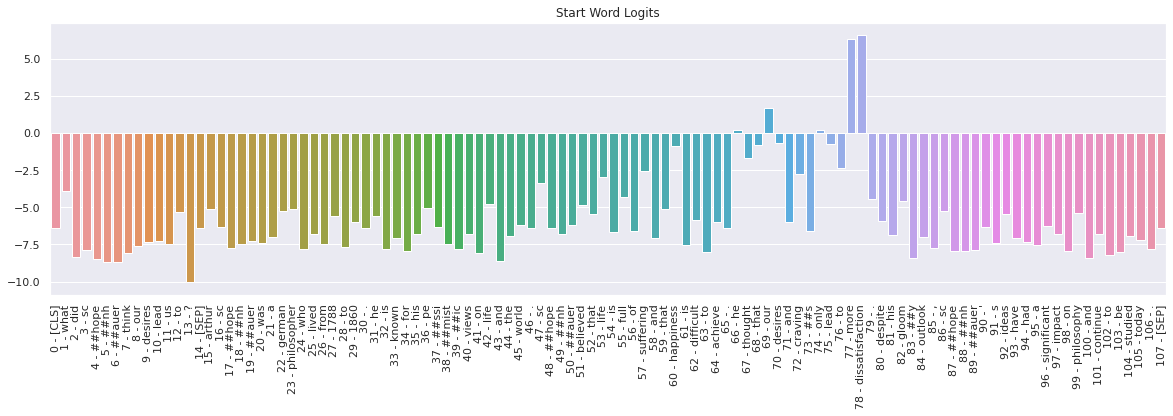

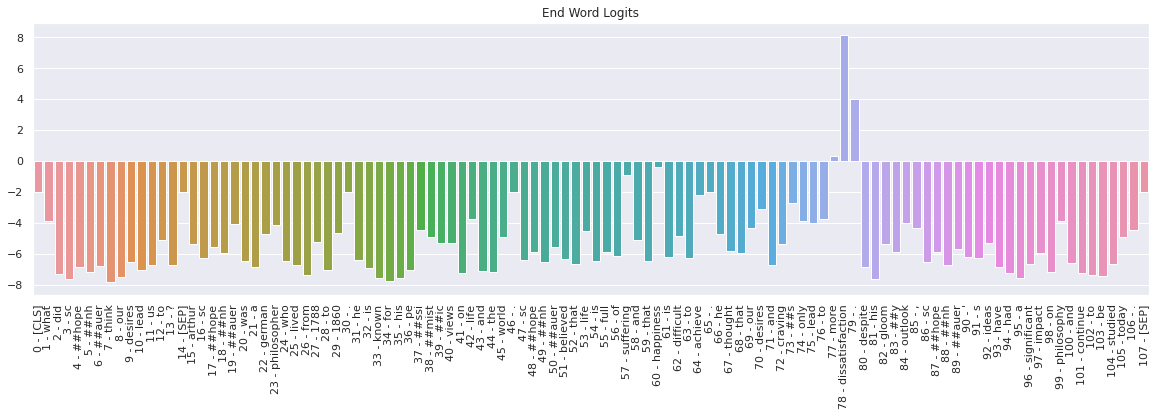

In [22]:
# Traza logits start y end para nuestro modelo de ajuste fino.

sns.set(rc={"figure.figsize":(20, 5)})

# Crea un diseño de barras mostrando el score de la palabra para el start de todos los tokens.
ax = sns.barplot(x=[f'{i} - {t}' for i, t in enumerate(token_labels)], y=output.start_logits.squeeze().tolist(), ci=None)
# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
# Turn on the vertical grid to help align words to scores.
plt.title('Start Word Logits')

plt.show()

# Crea un diseño de barras mostrando el score de la palabra para el end de todos los tokens.
ax = sns.barplot(x=[f'{i} - {t}' for i, t in enumerate(token_labels)], y=output.end_logits.squeeze().tolist(), ci=None)
# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
# Turn on the vertical grid to help align words to scores.
plt.title('End Word Logits')

plt.show()

In [23]:
PERSON = 'Ilya Sutskever'

# Nota este no es un modo eficiente de buscar en google. Sólo como propuesta educativa
google_html = BeautifulSoup(requests.get(f'https://www.google.com/search?q={PERSON}').text).get_text()[:512]

squad_pipe(f'Who is {PERSON}?', google_html)

{'score': 0.01632045768201351,
 'start': 29,
 'end': 42,
 'answer': 'GoogleIniciar'}